In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DKL/MC_dropout/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DKL/MC_dropout


#### Monte carlo dropout for Shift dataset

### Read libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import itertools
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)

In [33]:
import pandas as pd
import numpy as np
import os
import torch
import torch.optim as optim
from features import feature_prep, inverse_transform, format_predictions, calculate_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Read data and split dataset into train, val and test set

In [15]:
df = pd.read_csv('data.csv')
ind = int(df.shape[0]*80/100)
train = df[(df['type']=='train')]
val = df[(df['type']=='dev_in')]
test = df[df['type']=='dev_out']

In [5]:
features = ['draft_aft_telegram', 'draft_fore_telegram', 'stw',
    'diff_speed_overground', 'awind_vcomp_provider', 'awind_ucomp_provider',
    'rcurrent_vcomp', 'rcurrent_ucomp', 'comb_wind_swell_wave_height',
    'timeSinceDryDock']
X_train = train[features]
y_train = train['power']
X_test = test[features]
y_test = test['power']

In [6]:
batch_size = 200
# X_train, train_features, train_targets, X_val, X_test, scaler, scaler1, train_loader, val_loader, test_loader, train_loader_one, val_loader_one, test_loader_one = feature_prep(train, test, batch_size=batch_size)

X_train,y_train, train_features, train_targets, X_test,y_test, scaler,scaler1, train_loader,val_loader, test_loader, train_loader_one, test_loader_one= feature_prep(train,val, test, batch_size=batch_size)


Identified outliers: 0
Non-outlier observations: 523190


In [7]:
class MLP(nn.Module):
    "MLP model architechture"
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean
class LSTMModel(nn.Module):
    "LSTM model architechture"
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):

        super(LSTMModel, self).__init__()

        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)
        # LSTM layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bias = True,# bidirectional =True
        )

        self.lstm2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        # Fully connected layer

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.activation(out[:, -1, :].to(self.device))
        out = self.dropout(out)
        out = self.fc(out)
        out = self.dropout(out)
        out = self.fc1(out)
        return out



##### Define model hyperparameter

In [11]:
# net_dropout = MLP(input_dim=len(features),hidden_dim=30, n_hidden_layers=2, use_dropout=True)
input_dim = len(features)
output_dim = 1
hidden_dim = 1000
layer_dim = 3
kernel = 1
out_channels = 24

dropout_prob = 0.3968084179060663
n_epochs = 150
learning_rate = 0.001
weight_decay = 1e-6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_dropout = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device)
net_dropout = net_dropout.to(device)

### Training code

In [12]:
def train(model, trainloader, num_epochs=20):
 "Train function"
  optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
  criterion = nn.MSELoss()
  epoch_loss = []
  for epoch in range(num_epochs):
    model.train()

    batch_loss = []
    optimizer.zero_grad()
    for x_batch, y_batch in train_loader:
      x_batch = x_batch.view([batch_size, -1, input_dim]).to(device)
      y_batch = y_batch.to(device)
      optimizer.zero_grad()
      loss = criterion(y_batch, model(x_batch))
      loss.backward()
      optimizer.step()
      batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))
    print('epoch:',epoch, ' loss:', np.mean(batch_loss))
  return epoch_loss


In [13]:
epoch_loss = train(net_dropout, train_loader, 50)

epoch: 0  loss: 0.13513638135544373
epoch: 1  loss: 0.07752729249302562
epoch: 2  loss: 0.07964712474851318
epoch: 3  loss: 0.07347395451379722
epoch: 4  loss: 0.06539427628473558
epoch: 5  loss: 0.06774189604542452
epoch: 6  loss: 0.06270105558880258
epoch: 7  loss: 0.06039767575950627
epoch: 8  loss: 0.054053127497121205
epoch: 9  loss: 0.05362469942574291
epoch: 10  loss: 0.057331989362593705
epoch: 11  loss: 0.04890762176934494
epoch: 12  loss: 0.048691684341353736
epoch: 13  loss: 0.04537442543759344
epoch: 14  loss: 0.04509808213857802
epoch: 15  loss: 0.04333407387144536
epoch: 16  loss: 0.04232774666807904
epoch: 17  loss: 0.04147711580843588
epoch: 18  loss: 0.043246927674695936
epoch: 19  loss: 0.04280021448884993
epoch: 20  loss: 0.04158728748638304
epoch: 21  loss: 0.04164848209930366
epoch: 22  loss: 0.04125887445756457
epoch: 23  loss: 0.04018797156887118
epoch: 24  loss: 0.04051798950296686
epoch: 25  loss: 0.04103035069467859
epoch: 26  loss: 0.04164751134777217
epoch: 

#### Visulaize training loss

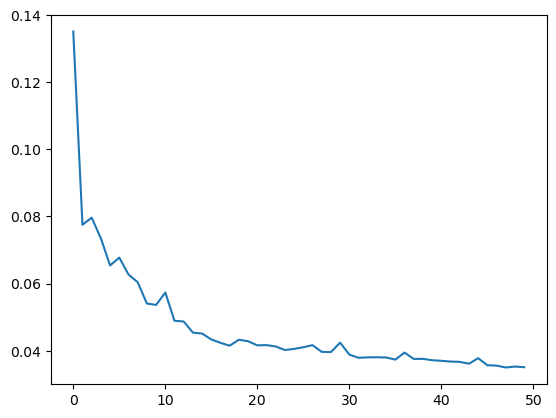

In [16]:
plt.plot(epoch_loss)

### Inference

In [17]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [20]:
n_dropout_samples = 10000

# # compute predictions, resampling dropout mask for each forward pass
# y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
# y_preds = np.array(y_preds)
y_preds = []
for i in range(n_dropout_samples):
  net_dropout.eval()
  enable_dropout(net_dropout)
  test_pred = []
  if i==0:
    test_actual = []
  with torch.no_grad():
    for x_test, test_y in test_loader:
        x_test = x_test.view([batch_size, -1, input_dim]).to(device)
        y_pred = net_dropout(x_test).clone().detach().cpu()
        test_pred.append(torch.flatten(y_pred).numpy().tolist())
        if i==0:
          test_actual.append(test_y.flatten().tolist())
    y_preds.append(list(itertools.chain.from_iterable(test_pred)))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
def inverse_transform(scaler, df, columns):
  for col in columns:
      df[col] = scaler.inverse_transform(df[col])
  return df

In [23]:
df_result = pd.DataFrame(y_preds).T
df_result.columns = ['pred_'+str(i) for i in range(len(y_preds))]
df_result['actual'] = list(itertools.chain.from_iterable(test_actual))
pred_cols = df_result.drop(['actual'], axis=1).columns

In [24]:
df_result = inverse_transform(scaler1, df_result, [list(df_result.columns)])
df_result['std_pred'] = df_result[pred_cols].std(axis=1)
df_result['mean_pred'] = df_result[pred_cols].mean(axis=1)

In [25]:
df_result

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_9993,pred_9994,pred_9995,pred_9996,pred_9997,pred_9998,pred_9999,actual,std_pred,mean_pred
0,20882.320824,20562.197462,20827.586690,20576.183937,20724.200017,21045.170306,20448.899401,20203.811356,21188.862324,20668.550907,...,21430.622204,20483.994904,20648.499158,20520.513677,20593.947559,20555.908962,20918.333142,21346.589095,222.947678,20710.119732
1,19907.312398,19802.672462,19628.706032,19840.396795,19596.960763,19646.803114,19680.446382,19614.362302,19736.087905,19556.635418,...,19592.709922,19595.114375,19676.935107,19437.265991,19786.910636,19733.501606,19379.085986,19979.905905,133.405979,19662.120067
2,21906.609283,21521.166581,22289.193493,21214.359555,21482.388417,22276.497408,21514.783135,22000.402511,21935.800668,21651.815835,...,21761.167318,21796.231556,21749.499546,21456.332546,21787.896546,21267.083043,21350.010136,21432.773086,309.204316,21630.640792
3,19203.133969,19088.155618,19055.453418,19161.900775,19144.443486,19146.741844,19076.804294,19146.069521,19239.005592,19037.966128,...,19075.305735,19059.773342,19200.271913,19226.125708,19175.767476,19130.172173,19112.553844,19120.396882,87.673439,19115.784693
4,19291.233200,19083.700287,19076.327840,19238.098433,19205.874641,19239.332845,19146.554136,19227.890253,19064.286262,19087.739511,...,19218.551300,19119.277302,18993.287065,19061.575360,19247.573483,19121.813024,19082.079195,19665.235035,87.211812,19129.130223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,22490.536300,21822.787445,22755.202285,22135.907110,21592.461535,21842.570679,22012.878358,22555.293091,22854.755718,21778.426784,...,22102.008431,22664.403646,22221.525794,21745.500783,22092.098192,22875.502204,22490.211691,26725.038018,370.655647,22291.650003
17996,23388.959124,22801.988320,23308.386137,23648.709071,23696.273065,23182.564642,23177.456414,23458.734484,22121.429353,23237.478783,...,22763.418669,22811.088874,23310.815649,22699.129022,23300.064921,22921.313032,22920.976009,26044.233065,421.818745,22910.557613
17997,22278.821169,23319.387909,22310.050788,23084.850814,22257.939965,22954.242482,22447.930644,22614.184385,22357.511789,21993.588015,...,22358.306760,22329.635394,22708.167045,22612.938824,21982.918209,21874.282154,22015.124415,26269.332582,368.637983,22311.484109
17998,22910.157232,22562.204142,22914.774868,23103.338370,22748.325718,23363.626727,23622.561932,23901.789355,21795.331754,22811.004733,...,23896.505028,23090.968274,22499.385811,23280.416865,22798.750963,23016.994143,22954.286161,26451.905525,428.132826,23000.971912


In [26]:
df_result.to_csv('df_result_power.csv')

In [27]:
df = df_result

/tmp/ipykernel_583/2747779439.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


(array([-20000., -10000.,      0.,  10000.,  20000.,  30000.,  40000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, -10000.0, '−10000'),
  Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000')])

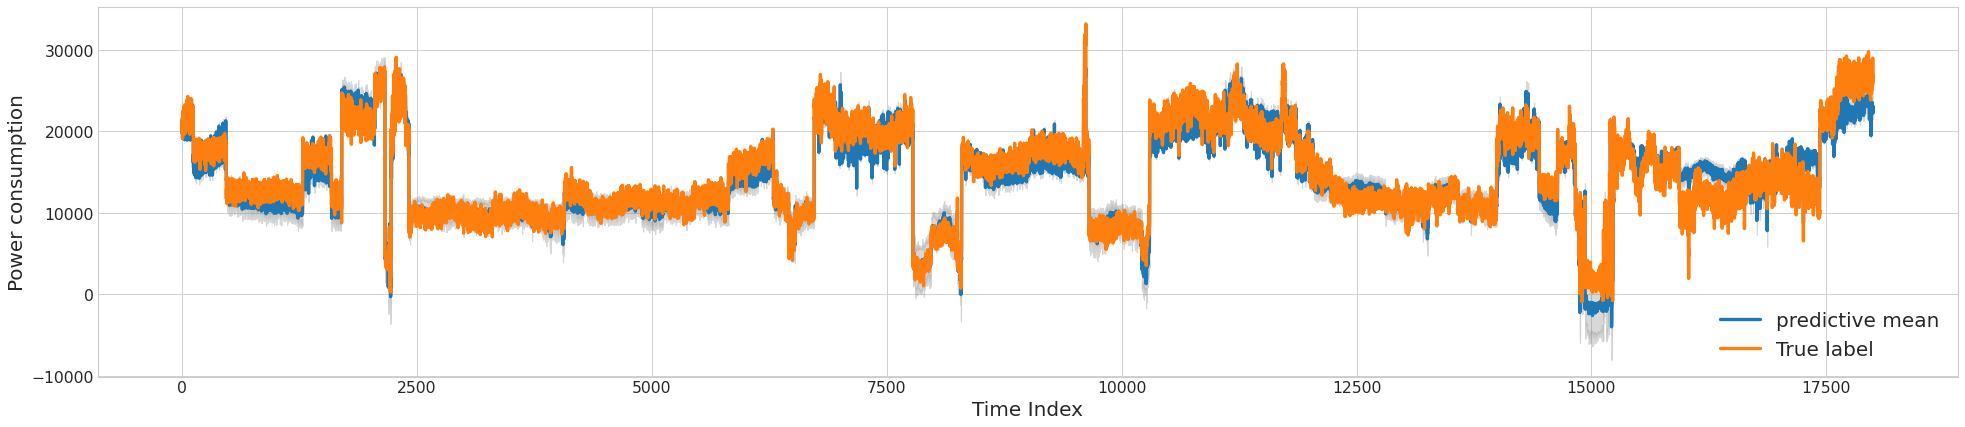

In [36]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30, 6), dpi=80)

y_actual = list(itertools.chain.from_iterable(test_actual))

plt.plot(df.index, df['mean_pred'], '-', linewidth=3, label="predictive mean")
plt.plot(df.index, df['actual'], '-', linewidth=3, label="True label")
plt.fill_between(df.index, df['mean_pred'] - 2 * df['std_pred'], df['mean_pred'] + 2 * df['std_pred'], color='gray', alpha=0.3,)
plt.legend(fontsize=18, loc = 'lower right')
plt.xlabel('Time Index', fontsize=18)
plt.ylabel('Power consumption', fontsize=18)
plt.xticks(fontsize=14, )
plt.yticks(fontsize=14, )


### Error metric

In [34]:
def calculate_metrics(df):

    return {
            'mae' : mean_absolute_error(df.actual, df.mean_pred),
            'mse' : mean_squared_error(df.actual, df.mean_pred) ** 0.5,
            'r2' : r2_score(df.actual, df.mean_pred),
            }
calculate_metrics(df)


{'mae': 1427.9819946523266,
 'mse': 1854.9673401387079,
 'r2': 0.8805755931196044}

In [35]:
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)
    
mean_absolute_percentage_error(df.actual, df.mean_pred)

0.06452777961772813